# Ethereum Price Investigation with Keras

This is a notebook to investigate the historical ethereum price, basic data wrangling to clean up and merge data to better understand and prepare for TIme series learning.

In [1]:
import pandas as pd
import os
os.environ['KERAS_BACKEND']='tensorflow'
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### Import ether prices

In [150]:
price_index = pd.read_csv('./data/evolution-of-the-ethereum-usd-price.csv')
price_index['timespan'] = pd.to_datetime(price_index['DateTime'])
price_index.count()

DateTime       8431
Price [USD]    8431
timespan       8431
dtype: int64

### Plot prices & transform data

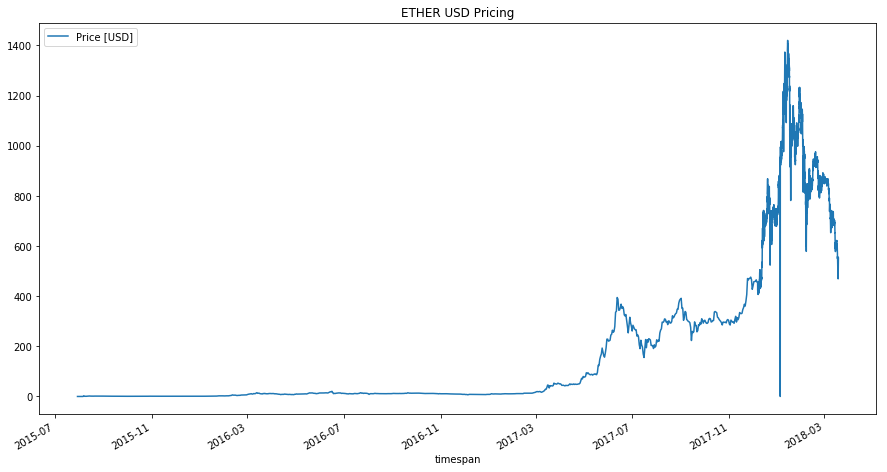

In [152]:
price_index.plot(figsize=(15, 8), title='ETHER USD Pricing', 
                 x='timespan', y='Price [USD]')


In [153]:
total_transaction = pd.read_csv('./data/total-number-of-transactions-per-day.csv')
total_transaction['timespan'] = pd.to_datetime(total_transaction['DateTime'])
total_transaction.count()

DateTime        963
Transactions    963
timespan        963
dtype: int64

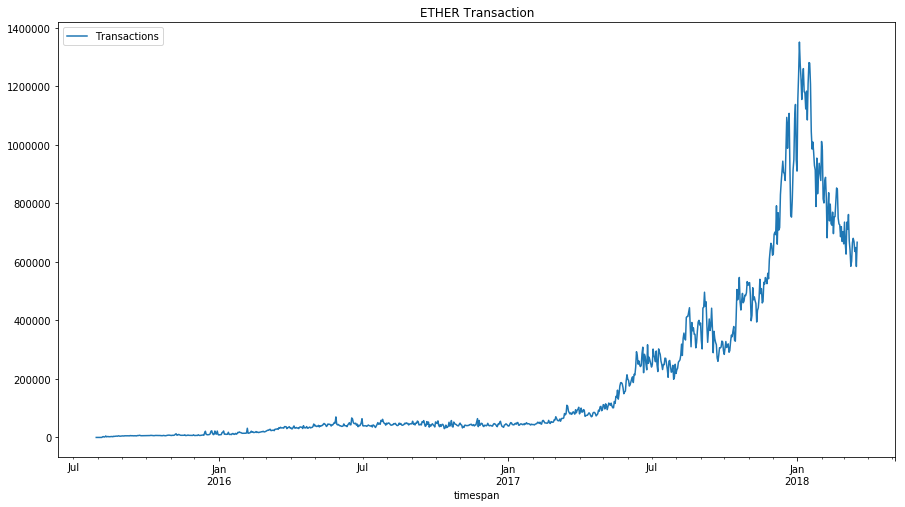

In [154]:
total_transaction.plot(figsize=(15, 8), title='ETHER Transaction', x='timespan', y='Transactions')


In [155]:
# Let's just work with daily value for now...
price_index['timespan'] = price_index['timespan'].apply(lambda x: x.replace(hour=0, minute=0, second=0))
new_price_index = price_index.drop_duplicates(subset='timespan', keep=('last'))
new_price_index.count()

DateTime       964
Price [USD]    964
timespan       964
dtype: int64

### Normalise series for prediction

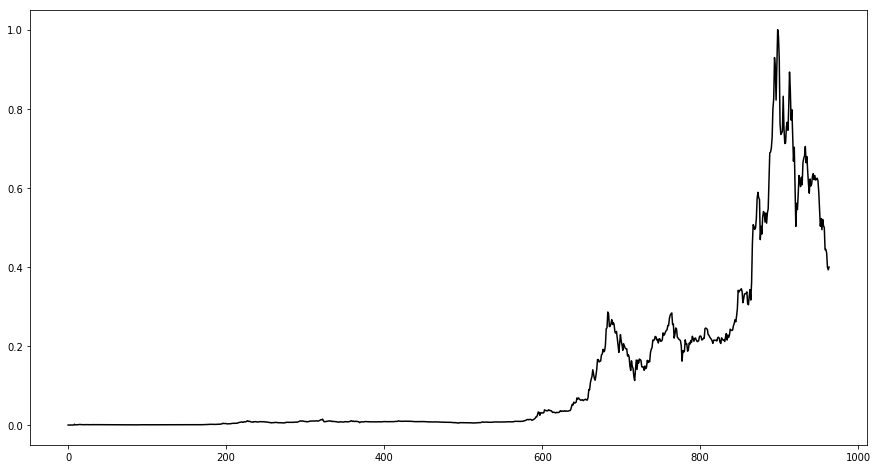

In [157]:
# convert it to array
price_index_arr = new_price_index['Price [USD]'].tolist()
price_index_arr = price_index_arr
def normalise_series(series):
    mMax = float(max(series))
    mMin = float(min(series))
    return [(s-mMin)/(mMax-mMin) for s in series]

price_index_arr = normalise_series(price_index_arr)
plt.figure(figsize=(15,8))
plt.plot(price_index_arr, color='k')

In [158]:
# get batches function
def window_transform_series(series, window_size):
    X = [series[i:i+window_size] for i, num in enumerate(series[:-window_size])]
    y = series[window_size:]
    
    # reshape each
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X, y


In [159]:
window_size=7
# tx, ty = get_batches(new_price_index['Price [USD]'], 6, 20)
X, y = window_transform_series(price_index_arr, window_size)

print('batches X and y\n', X[:5], y[:5])

batches X and y
 [[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.00200617]
 [0.         0.         0.         0.         0.         0.00200617
  0.00058498]
 [0.         0.         0.         0.         0.00200617 0.00058498
  0.00053804]] [[0.        ]
 [0.00200617]
 [0.00058498]
 [0.00053804]
 [0.00049589]]


### Create training and test data

In [160]:
# Splitting to training and test sets
SPLIT_RATIO = 2/3
train_test_split = int(np.ceil(SPLIT_RATIO * len(y)))
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

print('train test split count\n', len(X_train), len(X_test))

train test split count
 638 319


In [161]:
np.random.seed(0)

def build_rnn(window_size):
    model = Sequential()
    model.add(LSTM(10, input_shape = (window_size,1)))
    model.add(Dense(1, activation='tanh'))

    return model

### Build and train model

In [169]:
# BUILD MODEL
model = build_rnn(window_size)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [170]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [171]:
#Train
epochs = 200
model.fit(X_train, y_train, epochs=epochs, batch_size=50, verbose=1)

Epoch 1/200
638/638 [==============================] - 2s 2ms/step - loss: 9.8534e-05
Epoch 2/200
638/638 [==============================] - 0s 359us/step - loss: 7.6951e-05
Epoch 3/200
638/638 [==============================] - 0s 368us/step - loss: 6.0586e-05
Epoch 4/200
638/638 [==============================] - 0s 404us/step - loss: 4.4342e-05
Epoch 5/200
638/638 [==============================] - 0s 492us/step - loss: 3.8135e-05
Epoch 6/200
638/638 [==============================] - 0s 431us/step - loss: 2.4501e-05
Epoch 7/200
638/638 [==============================] - 0s 442us/step - loss: 1.7179e-05
Epoch 8/200
638/638 [==============================] - 0s 423us/step - loss: 1.5593e-05
Epoch 9/200
638/638 [==============================] - 0s 389us/step - loss: 1.3675e-05
Epoch 10/200
638/638 [==============================] - 0s 399us/step - loss: 8.2217e-06
Epoch 11/200
638/638 [==============================] - 0s 429us/step - loss: 8.0138e-06
Epoch 12/200
638/638 [==========

638/638 [==============================] - 0s 348us/step - loss: 4.4933e-06
Epoch 94/200
638/638 [==============================] - 0s 338us/step - loss: 4.5851e-06
Epoch 95/200
638/638 [==============================] - 0s 337us/step - loss: 3.6550e-06
Epoch 96/200
638/638 [==============================] - 0s 347us/step - loss: 3.9926e-06
Epoch 97/200
638/638 [==============================] - 0s 332us/step - loss: 4.2419e-06
Epoch 98/200
638/638 [==============================] - 0s 340us/step - loss: 4.8635e-06
Epoch 99/200
638/638 [==============================] - 0s 345us/step - loss: 3.6814e-06
Epoch 100/200
638/638 [==============================] - 0s 337us/step - loss: 4.5637e-06
Epoch 101/200
638/638 [==============================] - 0s 328us/step - loss: 4.7242e-06
Epoch 102/200
638/638 [==============================] - 0s 337us/step - loss: 4.3362e-06
Epoch 103/200
638/638 [==============================] - 0s 362us/step - loss: 4.5302e-06
Epoch 104/200
638/638 [=======

638/638 [==============================] - 0s 386us/step - loss: 2.8228e-06
Epoch 185/200
638/638 [==============================] - 0s 434us/step - loss: 3.3938e-06
Epoch 186/200
638/638 [==============================] - 0s 428us/step - loss: 2.7898e-06
Epoch 187/200
638/638 [==============================] - 0s 451us/step - loss: 2.6170e-06
Epoch 188/200
638/638 [==============================] - 0s 441us/step - loss: 2.9630e-06
Epoch 189/200
638/638 [==============================] - 0s 475us/step - loss: 3.4534e-06
Epoch 190/200
638/638 [==============================] - 0s 389us/step - loss: 2.8856e-06
Epoch 191/200
638/638 [==============================] - 0s 415us/step - loss: 2.1016e-06
Epoch 192/200
638/638 [==============================] - 0s 438us/step - loss: 2.9551e-06
Epoch 193/200
638/638 [==============================] - 0s 375us/step - loss: 3.3333e-06
Epoch 194/200
638/638 [==============================] - 0s 405us/step - loss: 3.3552e-06
Epoch 195/200
638/638 [=

In [172]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [173]:
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error\n', str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error\n', str(testing_error))

training error
 2.7086208037558367e-06
testing error
 0.004758232951946674


### Plot training and test prediction

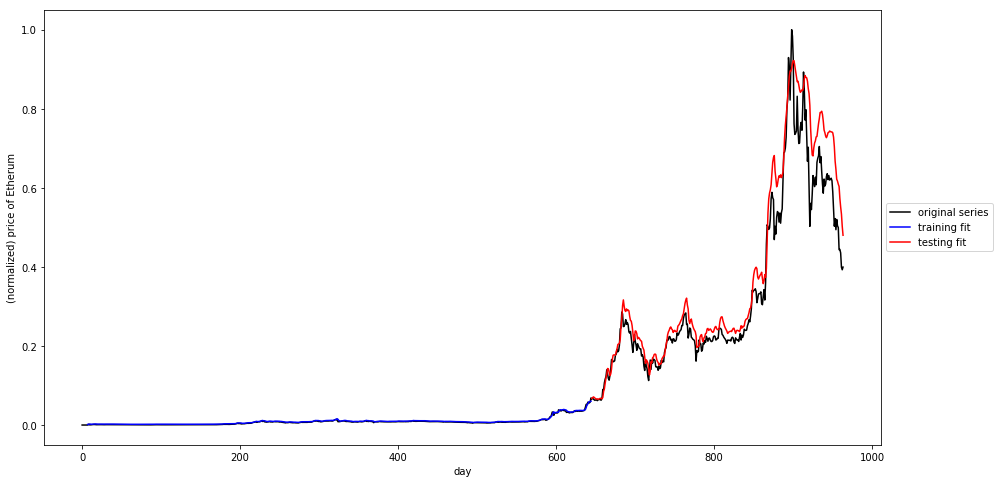

In [174]:
plt.figure(figsize=(15, 8))
# plot original series
plt.plot(price_index_arr,color = 'k')
# plot training set prediction

split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Etherum')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()